# Loading packages

In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install tabulate


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

# Calculating stock volatility

In [4]:
# Download the data (Toronto)

ticker = yf.Ticker('ENB.TO')

stock_data = ticker.history(interval = '1d', start='2010-01-01', end='2025-01-01')

close = stock_data['Close']

In [5]:
# Price changes

returns = close.pct_change()

In [6]:
# Annualized volatility
vols = {}
trading_days = 251

for year in range(1, 16):
    start_date = f'2010-01-01'
    end_date   = f'{2010 + year}-01-01'
    
    yearly_returns = returns.loc[start_date:end_date]
    annual_vol_pct = yearly_returns.std() * np.sqrt(year * trading_days)
    vols[year] = annual_vol_pct

# 4. Build a DataFrame of the results
s_vol_df = pd.DataFrame.from_dict(
    vols, 
    orient='index', 
    columns=['Annualized stock volatility']
)
s_vol_df.index.name = 'Year'
s_vol_df.reset_index(inplace=True)

In [7]:
print(s_vol_df.to_markdown(index=False))

|   Year |   Annualized stock volatility |
|-------:|------------------------------:|
|      1 |                      0.138719 |
|      2 |                      0.224799 |
|      3 |                      0.269207 |
|      4 |                      0.30418  |
|      5 |                      0.358387 |
|      6 |                      0.450046 |
|      7 |                      0.52737  |
|      8 |                      0.55629  |
|      9 |                      0.610433 |
|     10 |                      0.633025 |
|     11 |                      0.787199 |
|     12 |                      0.800775 |
|     13 |                      0.820834 |
|     14 |                      0.836688 |
|     15 |                      0.845211 |


# Risk free rate for each T

In [8]:
# Risk free rate for each T = government bond (From Market insider as April 25)
# Made assumption about the maturity of the bond, picked the ones that are the closest to the 
# Selected CA government bond:
# Year 1 (2025 Dec 31): CA135087Q806
# Year 2 (2026 Dec 31): CA135087S547
# Year 3 (2027 Dec 31): CA135087P576
# Year 4 (2028 Dec 31): CA135087Q988
# Year 5 (2029 Dec 31): CA135087N670
# Year 6 (2030 Dec 31): CA135087L443
# Year 7 (2031 Dec 31): CA135087N266
# Year 8 (2032 Dec 31): CA135087P329
# Year 9 (2033 Dec 31): CA135087Q723
# Year 10 (2034 Dec 31): CA135087S216
# Year 11 (2035 Dec 31): CA135087S620
# Year 12 (2036 Dec 31): CA135087S620
# Year 13 (2037 Dec 31): CA135087XW98
# Year 14 (2038 Dec 31): CA135087XW98
# Year 15 (2039 Dec 31): CA135087XW98

r_data = {
    'Year': list(range(1, 16)),
    'Risk-free rate': [2.74 / 100, 2.62 / 100, 2.67 / 100, 2.76 / 100, 2.83 / 100, 2.93 / 100, 3.01 / 100, 3.08 / 100, 3.15 / 100, 3.20 / 100, 3.22 / 100, 3.22 / 100, 3.30 / 100, 3.30 / 100, 3.30 / 100]
}
r_df = pd.DataFrame(r_data)

In [9]:
print(r_df.to_markdown(index=False))

|   Year |   Risk-free rate |
|-------:|-----------------:|
|      1 |           0.0274 |
|      2 |           0.0262 |
|      3 |           0.0267 |
|      4 |           0.0276 |
|      5 |           0.0283 |
|      6 |           0.0293 |
|      7 |           0.0301 |
|      8 |           0.0308 |
|      9 |           0.0315 |
|     10 |           0.032  |
|     11 |           0.0322 |
|     12 |           0.0322 |
|     13 |           0.033  |
|     14 |           0.033  |
|     15 |           0.033  |


# Estimating asset volatility using iteration for each T

In [10]:
# Parameters for each T

df_vol = pd.merge(r_df, s_vol_df, on='Year')

# Parameters (E and D based on 2024 Dec 31)

E = 132.88e9 # Market cap (CAD)
D = 103.01e9 # Total debt (CAD)
A = E + D # Total asset
tol = 1e-5 # Convergence tolerance
max_iter = 100 # Max iterations

In [11]:
# Estimating the asset volatility function

def estimate_asset_volatility(T, r_pct, sigma_S):
    r = r_pct
    sigma_A = sigma_S
    for i in range(max_iter):
        d1 = (np.log(A / D) + (r + 0.5 * sigma_A**2) * T) / (sigma_A * np.sqrt(T))
        d2 = d1 - sigma_A * np.sqrt(T)
        S_theo = A * norm.cdf(d1) - D * np.exp(-r * T) * norm.cdf(d2)
        delta = norm.cdf(d1)
        sigma_A_new = (sigma_S * S_theo) / (A * delta)
        if abs(sigma_A_new - sigma_A) < tol:
            sigma_A = sigma_A_new
            break
        sigma_A = sigma_A_new
        i += 1
    return sigma_A

In [12]:
# Finding the asset volatility

df_vol['Estimated asset volatility'] = df_vol.apply(lambda row: estimate_asset_volatility(row['Year'], row['Risk-free rate'], row['Annualized stock volatility']), axis=1)

In [13]:
print(df_vol.to_markdown(index=False))

|   Year |   Risk-free rate |   Annualized stock volatility |   Estimated asset volatility |
|-------:|-----------------:|------------------------------:|-----------------------------:|
|      1 |           0.0274 |                      0.138719 |                    0.0797796 |
|      2 |           0.0262 |                      0.224799 |                    0.131644  |
|      3 |           0.0267 |                      0.269207 |                    0.160758  |
|      4 |           0.0276 |                      0.30418  |                    0.185988  |
|      5 |           0.0283 |                      0.358387 |                    0.227176  |
|      6 |           0.0293 |                      0.450046 |                    0.306713  |
|      7 |           0.0301 |                      0.52737  |                    0.390266  |
|      8 |           0.0308 |                      0.55629  |                    0.433134  |
|      9 |           0.0315 |                      0.610433 |         

# Modelling and plotting

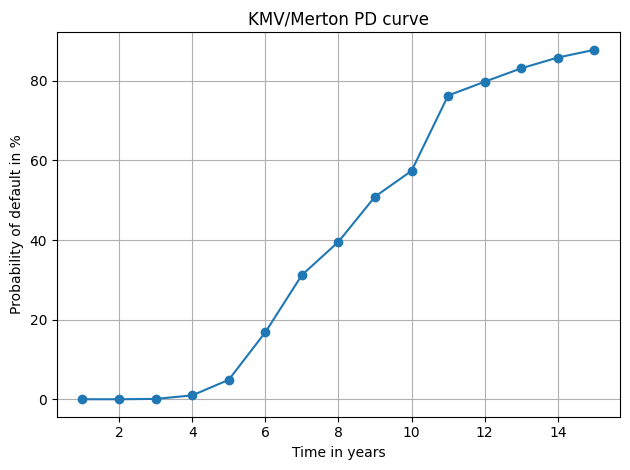

In [14]:
T_vals = df_vol['Year'].values
r_vals = df_vol['Risk-free rate'].values
sigma_A = df_vol['Estimated asset volatility'].values

d1 = (np.log(A / D) + (r_vals + 0.5 * sigma_A**2) * T_vals) / (sigma_A * np.sqrt(T_vals))
d2 = d1 - sigma_A * np.sqrt(T_vals)
PD = norm.cdf(-d2) * 100

pd_df = pd.DataFrame({
    'Year': T_vals,
    'Probability of default in %': PD
})

plt.figure()
plt.plot(pd_df['Year'], pd_df['Probability of default in %'], marker='o')
plt.title('KMV/Merton PD curve')
plt.xlabel('Time in years')
plt.ylabel('Probability of default in %')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
print(pd_df.to_markdown(index=False))

|   Year |   Probability of default in % |
|-------:|------------------------------:|
|      1 |                   5.73511e-25 |
|      2 |                   0.000175258 |
|      3 |                   0.0891765   |
|      4 |                   0.968819    |
|      5 |                   4.89011     |
|      6 |                  16.8232      |
|      7 |                  31.1994      |
|      8 |                  39.5545      |
|      9 |                  50.898       |
|     10 |                  57.3758      |
|     11 |                  76.2955      |
|     12 |                  79.7635      |
|     13 |                  83.1324      |
|     14 |                  85.8418      |
|     15 |                  87.7792      |
